## HLA-zoo

To know:
- the alignment of each set of reads againts the graphs is done with `rules/alignment_simreads.smk`
- due to the large amount of graphs for the same set of sequences, paths to gfa are indexed and stored in a json file, their identifiers are used to label the `*.gaf` file with the alignment results 
- in each folder you will find a file `gfaid_to_path`, the information to track the source gfa is in that file

In [1]:
import sys
import json
from pathlib import Path
from tqdm import tqdm

# add parent folder to the path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from utils.load_gaf import load_gaf, ABBV

In [2]:
tool="vg"
PATH_TOOL=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo").joinpath(tool)

with open(Path(PATH_TOOL).joinpath("gfaid_to_paths.json")) as fp:
    gfaid_to_paths=json.load(fp)

In [3]:
path_gaf = list(Path(PATH_TOOL).rglob("*.gaf"))[0]
seqsid, gfaid, _ = path_gaf.stem.split(".")
gfaid = gfaid.replace("gfaid","")
path_gfa = "../"+ gfaid_to_paths[gfaid]

In [4]:
gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf["seqsid"] = seqsid 
gaf["tool"] = tool
gaf["gfa"] = path_gfa

In [5]:
path_gfa

'../HLA-zoo-vg/output-HLA-zoo-mafft.op1.53-ep0/B-3106.gfa'

## Generic load

In [6]:
BASEPATH_ALIGN=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo")

In [7]:
data_gafs = []

for TOOL in ["pangeblocks","pggb","PanPA","vg"]:

    # load id to gfas
    with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
        gfaid_to_paths=json.load(fp)

    for path_gaf in tqdm(list(BASEPATH_ALIGN.joinpath(TOOL).rglob("*.gaf")), desc=TOOL):

        # load info related to the gfa
        seqsid, gfaid, _ = path_gaf.stem.split(".")
        gfaid = gfaid.replace("gfaid","")
        path_gfa =  "../" + gfaid_to_paths[gfaid]

        # 
        data_gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
        data_gaf["seqsid"] = seqsid 
        data_gaf["tool"] = TOOL
        data_gaf["gfa"] = path_gfa

        data_gafs.append(data_gaf)

vg: 100%|██████████| 84/84 [00:01<00:00, 57.24it/s] 


In [8]:
data_gafs=pd.concat(data_gafs, ignore_index=True)

In [9]:
def get_id_plot(path_gfa):

    if "pangeblocks" in path_gfa:
        # loss function info
        *_,mafft,_,loss_func, pen_len,_ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        *_,loss_func,pen_len,_= path_gfa.split("/")
        p, ml = pen_len.split("-")
        p=p.replace("penalization","p")
        ml=ml.replace("min_len","l")
        loss_func=loss_func[0]
        return "-".join(["mafft",op_ep,loss_func,p,ml])
    
    if "pggb" in path_gfa:
        return "pggb"

    if "PanPA" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["panpa","mafft",op_ep])

    if "vg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["vg","mafft",op_ep])

In [10]:
data_gafs["id_plot"] = data_gafs["gfa"].apply(get_id_plot)

In [11]:
iter_seqsid=iter(data_gafs["seqsid"].unique())

Text(0.5, 1.0, 'Boxplot | gene B-3106')

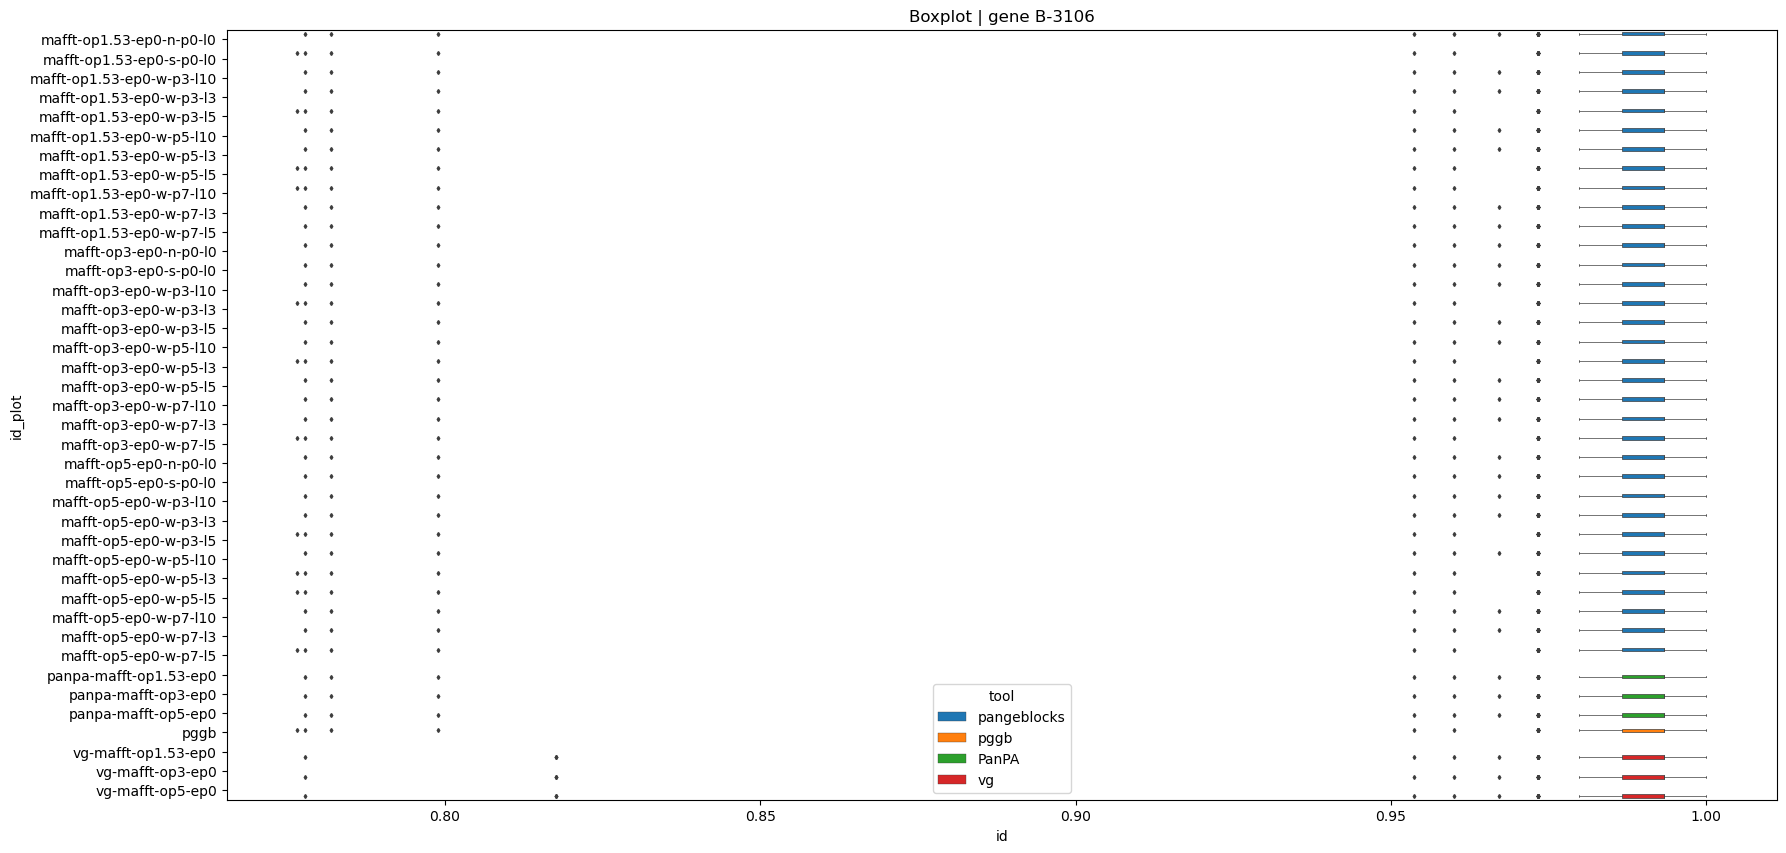

In [12]:
seqid= next(iter_seqsid)
# seqid="C-3107"

data_boxplot = data_gafs.query(f"seqsid=='{seqid}'")
order_labels = sorted(list(data_boxplot["id_plot"].unique()))

plt.figure(figsize=(20,10))
# fig, (ax_boxplot, ax_counts) = plt.subplots(nrows=2, ncols=1,)
ax_boxplot = sns.boxplot(
    data=data_boxplot, 
    x="id",
    y="id_plot",
    orient="h",
    hue="tool",
    order=order_labels,
    saturation=1,
    linewidth=0.5,
    fliersize=2.0,
    )
ax_boxplot.set_title(f"Boxplot | gene {seqid}")

Text(0.5, 1.0, 'Number of aligned reads | gene B-3106')

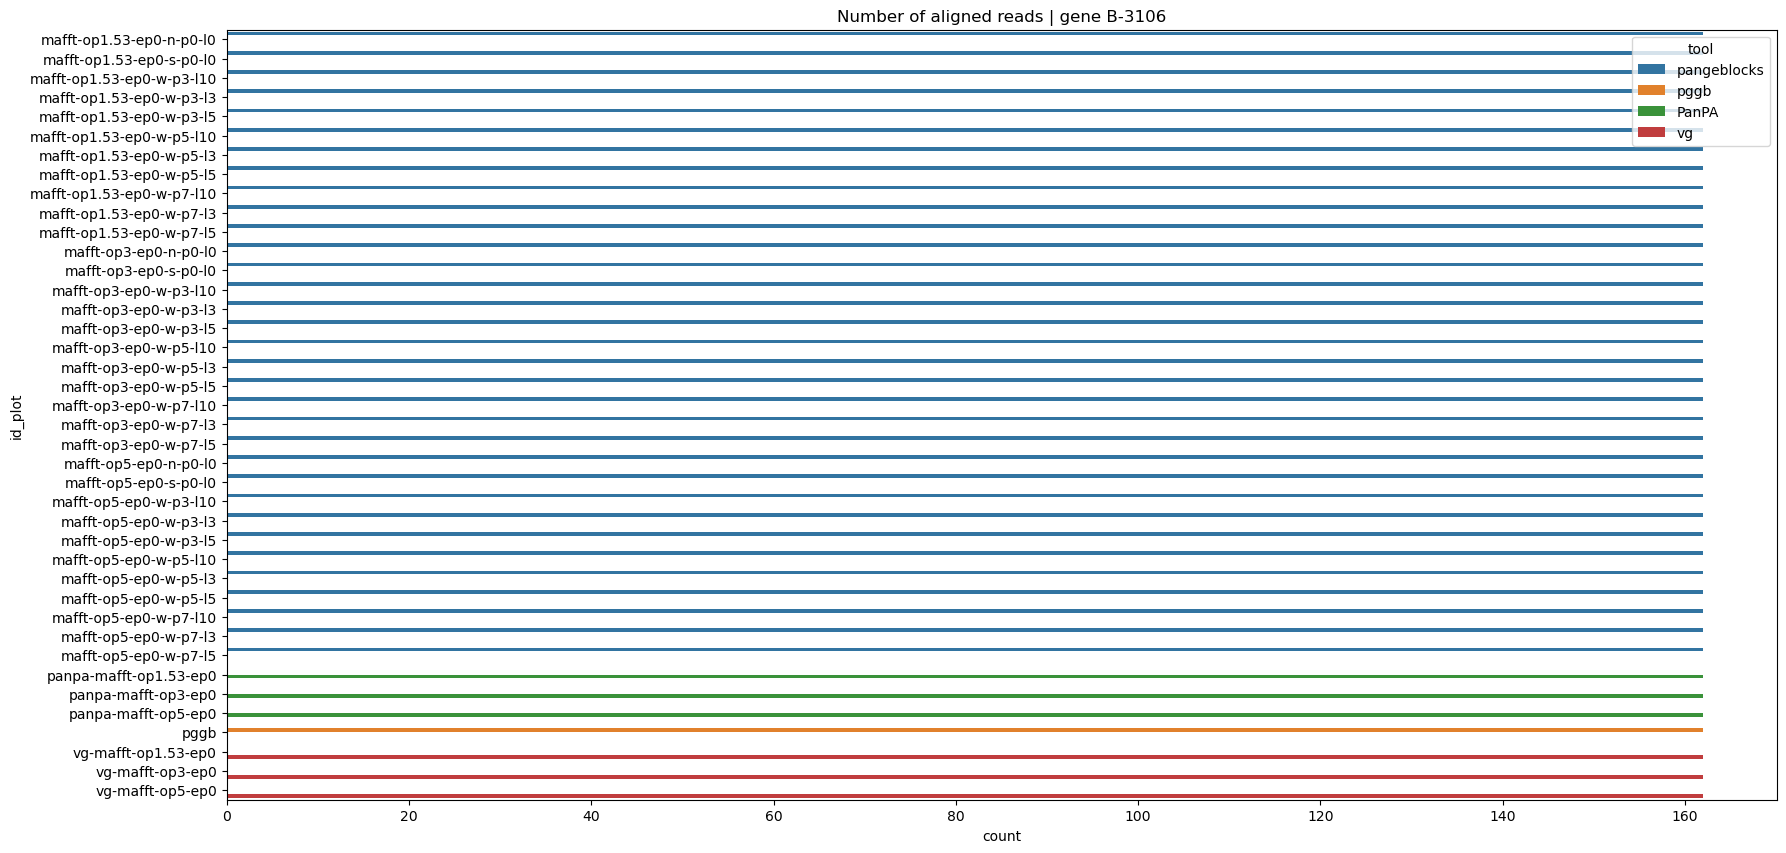

In [13]:
plt.figure(figsize=(20,10))
ax_count=sns.countplot(
    data=data_boxplot, 
    y="id_plot", 
    hue="tool", 
    orient="h", 
    order=order_labels
    )
ax_count.set_title(f"Number of aligned reads | gene {seqid}")


Text(0.5, 1.0, 'Number of existing paths the reads are aligned against | gene B-3106 ')

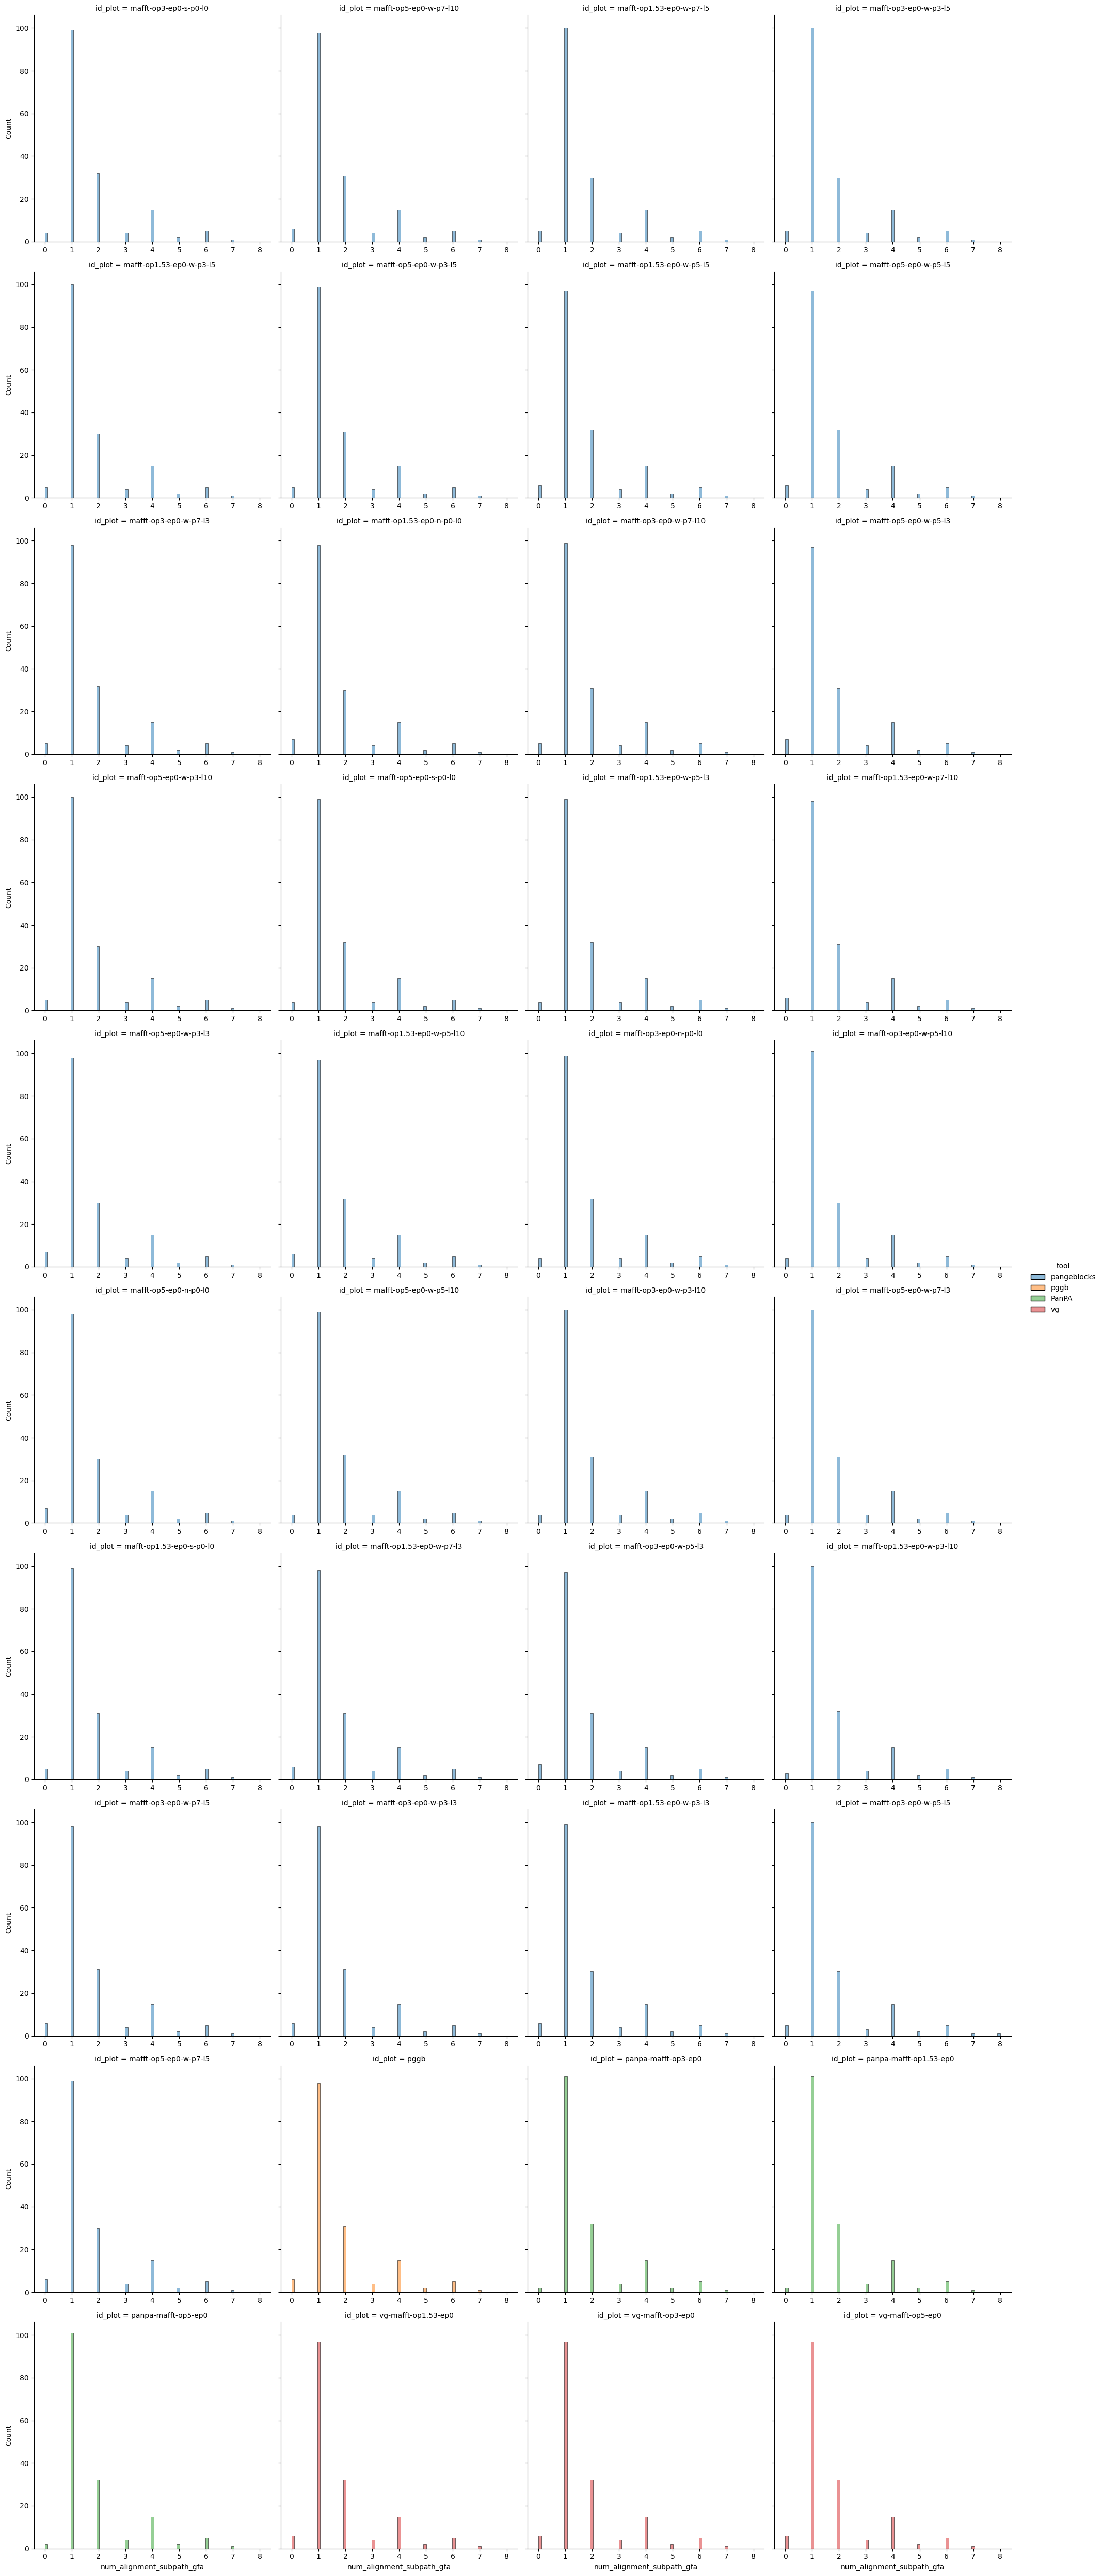

In [15]:
ax_align_subpaths = sns.displot(
    data=data_boxplot,
    col="id_plot",
    x="num_alignment_subpath_gfa",
    hue="tool",
    col_wrap=4,
    facet_kws=dict(sharex=False)
)

ax_count.set_title(f"Number of existing paths the reads are aligned against | gene {seqid} ")


In [ ]:
data_boxplot.head()

,query_seq_name,query_seq_len,query_start,query_end,strand_rel_path,path_matching,path_len,start_pos_path,end_pos_path,num_residue_matches,...,NM,AS,dv,id,cigar,num_alignment_subpath_gfa,seqsid,tool,gfa,id_plot
266070,gi|568815592:29926658-29929838_1585_1593_0_1_0...,150,0,150,+,>285>212>283>233>163>69>251>286>174>70>237>71>...,266,17,167,150,...,0,150.00,dv:f:0,1.000000,cg:Z:150=,1,K-3138,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op5-ep0-w-p7-l10
266071,gi|568815592:29926658-29929838_1034_1076_0_1_0...,150,0,150,+,>31>211>208>32>33>34>35>36>37>167>189>133>39,286,128,278,149,...,1,147.06,dv:f:0.00666667,0.993333,cg:Z:80=1X69=,2,K-3138,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op5-ep0-w-p7-l10
266072,gi|568815592:29926658-29929838_391_500_0_1_0_0...,150,0,150,+,>13>14>15>124>194>186>16>260>17>166>19>20>125>...,192,26,176,148,...,2,144.12,dv:f:0.0133333,0.986667,cg:Z:9=1X50=1X89=,1,K-3138,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op5-ep0-w-p7-l10
266073,gi|568815592:29926658-29929838_2563_2568_0_1_0...,150,0,150,+,>103>268>104>105>238>202>266>135>108>110>153>1...,227,28,178,149,...,1,147.06,dv:f:0.00666667,0.993333,cg:Z:7=1X142=,1,K-3138,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op5-ep0-w-p7-l10
266074,gi|568815592:29926658-29929838_2952_3030_0_1_0...,150,0,150,+,>315>115>297>116>117>136>118>235>263,164,6,156,148,...,2,144.12,dv:f:0.0133333,0.986667,cg:Z:40=1X74=1X34=,3,K-3138,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op5-ep0-w-p7-l10



___
## Checking manually reads for gene C-3107
- Why pggb and vg align less reads than pangeblocks?
- get reads aligned by pangeblocks and not by pggb 
- get reads aligned by pangeblocks and not by vg


In [ ]:
seqid="C-3107"
TOOL="pggb"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pggb/C-3107/C-3107.gfaid16.alignment.gaf"
path_gfa="../"+gfaid_to_paths["16"]

gaf_pggb = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pggb.shape

(160, 18)

<Axes: xlabel='id', ylabel='Count'>

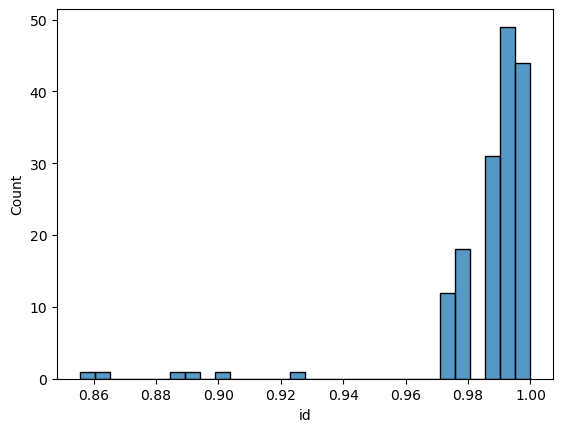

In [ ]:
sns.histplot(data=gaf_pggb,x="id")

In [ ]:
TOOL="vg"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/vg/C-3107/C-3107.gfaid24.alignment.gaf"
path_gfa="../" + gfaid_to_paths["24"]

gaf_vg=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_vg.shape

(157, 18)

In [ ]:
TOOL="pangeblocks"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pangeblocks/C-3107/C-3107.gfaid537.alignment.gaf"
path_gfa="../" + gfaid_to_paths["537"]

gaf_pangeblocks=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pangeblocks.shape

(161, 18)